# Proyecto procesamiento de imagenes

In [13]:
import cv2
from pyzbar.pyzbar import decode
import matplotlib.pyplot as plt
import numpy as np
# Get file names in /png
import os

In [3]:
# Decode QR codes
def decode_qr(qr_image):
  decoded_objects = decode(qr_image)
  if not decoded_objects:
      return False, ""
  return True, decoded_objects[0].data.decode("utf-8")


def get_txt_content(file_name):
  with open(file_name, 'r') as file:
    content = file.read()
  return content

def checkQr(image, txt_file_path):
  content = get_txt_content(txt_file_path)

  ok, decoded = decode_qr(image)
  if ok:
    return decoded == content
  return False

In [4]:
class Pipeline:
    def __init__(self, steps):
        self.steps = steps

    def run(self, data):
        for step in self.steps:
            data = step(data)
        return data


In [5]:

def grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


In [6]:

def threshold(threshold_value=128):
    def inner(image, threshold_value=threshold_value):
        _, thresholded_image = cv2.threshold(image, threshold_value, 255, cv2.THRESH_BINARY)
        return thresholded_image
    return inner

def otsu_threshold(image):
    _, thresholded_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return thresholded_image

def histogram_based_threshold(image):
    # Calculate histogram
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])

    # Calculate derivative of histogram
    derivative = np.gradient(hist.flatten())

    ## Plot derivative for debugging
    plt.plot(derivative)
    plt.title('Histogram Derivative')
    plt.xlabel('Pixel Value')
    plt.ylabel('Derivative')
    plt.show()

    # Find zero crossings in the derivative
    zero_crossings = cv2.findNonZero((derivative > 0).astype('uint8'))

    if zero_crossings is None or len(zero_crossings) == 0:
        return image
    
    # Find the index of the first zero crossing
    threshold_index = zero_crossings[0][0][0]
    threshold_value = threshold_index
    
    print(f"Calculated threshold value: {threshold_value}")

    
    # Apply threshold
    _, thresholded_image = cv2.threshold(image, threshold_value, 255, cv2.THRESH_BINARY)
    

    return thresholded_image



In [7]:
def gaussian_blur(kernel_size=5):
    def inner(image, kernel_size=kernel_size):
        return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)
    return inner

def median_blur(kernel_size=5):
    def inner(image, kernel_size=kernel_size):
        return cv2.medianBlur(image, kernel_size)
    return inner


In [8]:
def opening(kernel):
    def inner(image, kernel=kernel):
        return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
    return inner

def squared_opening(kernel_size=5):
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
    return opening(kernel)

In [9]:
def closing(kernel):
    def inner(image, kernel=kernel):
        return cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    return inner

In [10]:
def clahe_enhancement(clip_limit=2.0, tile_grid_size=(8, 8)):
    def inner(image, clip_limit=clip_limit, tile_grid_size=tile_grid_size):
        clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
        return clahe.apply(image)
    return inner

In [11]:
def show_image(label, image):
  ## Create a plot
  plt.imshow(image, cmap='gray')
  plt.title(label)
  plt.axis('off')
  plt.show()

def plot_histogram(image):
  plt.hist(image.ravel(), bins=256, range=[0, 256])
  plt.title('Histogram')
  plt.xlabel('Pixel value')
  plt.ylabel('Frequency')
  plt.show()
    

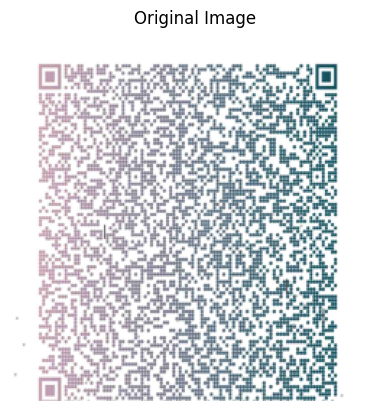

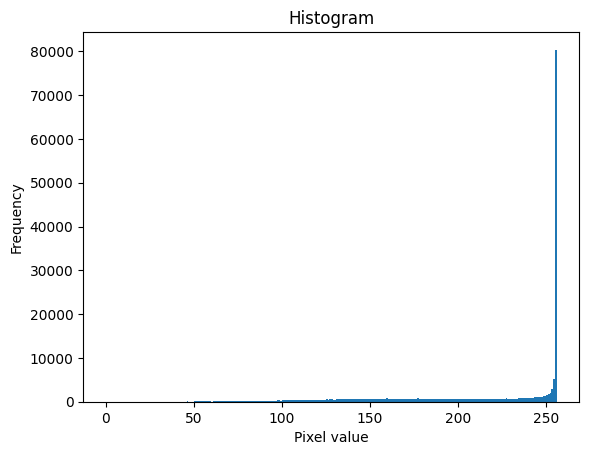

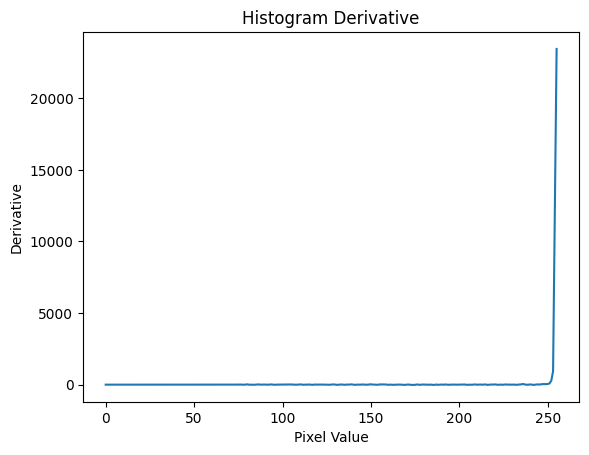

Calculated threshold value: 0


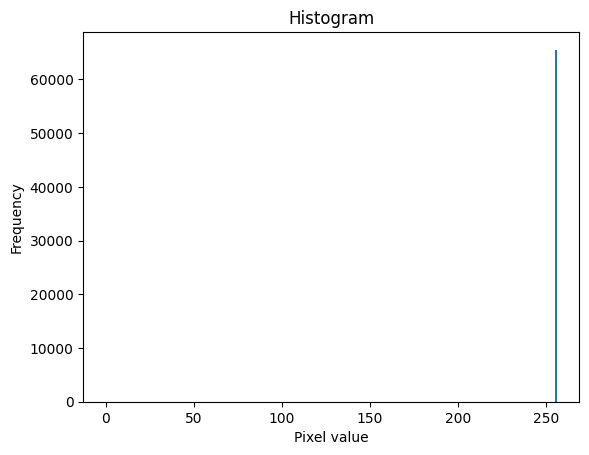

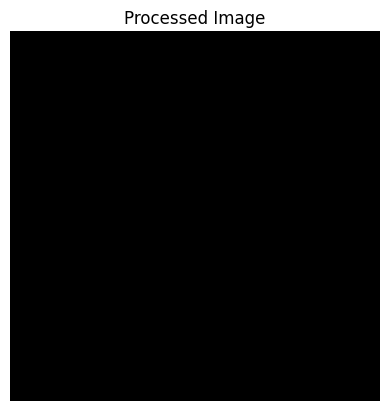

Original QR code validity: False
Processed QR code validity: False


In [24]:
''' 
This script test the transformation pipeline for a single image.
'''
image_name = "000005"

image = cv2.imread(f"png/{image_name}.png")
if image is None:
    raise FileNotFoundError("Image not found. Please check the file path.")

## Show original image
show_image("Original Image", image)
plot_histogram(image)

## Create a pipeline with the steps
pipeline = Pipeline([
    grayscale,
    # median_blur(kernel_size=5),
    histogram_based_threshold,
    # threshold(threshold_value=140),
    # squared_opening(kernel_size=3),
    # clahe_enhancement(clip_limit=2.0, tile_grid_size=(15,15)),
    # bluring(kernel_size=3),
    # otsu_threshold,
])

# Run the pipeline
processed_image = pipeline.run(image)

# Show histogram of processed image
plot_histogram(processed_image)

# Show processed image
show_image("Processed Image", processed_image)

## Check if the QR code is valid
txt_file_path = f"txt/{image_name}.txt"
original_validity = checkQr(image, txt_file_path)
processed_validity = checkQr(processed_image, txt_file_path)

print(f"Original QR code validity: {original_validity}")
print(f"Processed QR code validity: {processed_validity}")


In [ ]:
'''
This script processes images in a directory, aplying a series of transformations defined in a pipeline.
'''



def checAll():
  files = os.listdir("png")
  files = [file.split(".")[0] for file in files]

  # Set pipeline
  pipeline = Pipeline([
      # threshold(128),
      # grayscale
  ])

  # Initialize counters to compare original vs transformed 
  enhanced_count = 0
  worsened_count = 0
  same_ok_count = 0
  same_false_count = 0


  for file in files:
    # Read image
    img = cv2.imread("png/" + file + ".png")
    if img is None:
      print(f"Image {file}.png not found.")
      continue

    # Read text file
    file_name = "txt/" + file + ".txt"

    # Apply pipeline
    img_transformed = pipeline.run(img)

    # Show result of pipeline 
    ok = checkQr(img, file_name)
    transformed_ok  = checkQr(img_transformed, file_name)

    if ok:
      if transformed_ok: same_ok_count += 1
      else: worsened_count += 1
    else:
      if transformed_ok: enhanced_count += 1
      else: same_false_count += 1
  

  # Print summary
  print(f"Total images: {len(files)}")
  print(f"enhanced_count: {enhanced_count}")
  print(f"worsened_count: {worsened_count}")
  print(f"same_ok_count: {same_ok_count}")
  print(f"same_false_count: {same_false_count}")


## Run the check for all images
# checAll()


In [29]:
# Divides images in 2 folders depending on if they are recognized by the scan or not.
def divide_imgs_by_scan(folder_path, pipeline=None, pipeline_name=""):
    # Before the for loop in divide_imgs_by_scan
    os.makedirs(os.path.join(folder_path,pipeline_name+"_recognized"), exist_ok=True)
    os.makedirs(os.path.join(folder_path,pipeline_name+"_not_recognized"), exist_ok=True)
    for filename in os.listdir(folder_path):
        if filename.endswith(".png"):
            img_path = os.path.join(folder_path, filename)
            og_img = cv2.imread(img_path)
            if og_img is None:
                print(f"Image {filename} not found.")
                continue
            
            # Apply pipeline if provided
            if pipeline:
                img = pipeline.run(og_img)
            else:
                # This is to make sure the original image is used if no pipeline is provided
                img = og_img

            # Check QR code validity
            txt_file_path = f"txt/{filename.split('.')[0]}.txt"
            ok = checkQr(img, txt_file_path)

            # Move image to appropriate folder
            target_folder = pipeline_name + ("_recognized" if ok else "_not_recognized")
            target_path = os.path.join(target_folder, filename)
            target_path = os.path.join(folder_path, target_path)
            cv2.imwrite(target_path, og_img)
            print(f"Moved {filename} to {target_folder}")

def show_random_images(folder_path, n=5):
    images = [f for f in os.listdir(folder_path) if f.endswith('.png')]
    selected_images = np.random.choice(images, n, replace=False)
    
    plt.figure(figsize=(15, 10))
    for i, img_name in enumerate(selected_images):
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            plt.subplot(1, n, i + 1)
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.title(img_name)
            plt.axis('off')
    plt.show()

In [27]:
divide_imgs_by_scan("png")

Moved 000000.png to _recognized
Moved 000001.png to _not_recognized
Moved 000002.png to _recognized
Moved 000003.png to _recognized
Moved 000004.png to _recognized
Moved 000005.png to _not_recognized
Moved 000006.png to _recognized
Moved 000007.png to _not_recognized
Moved 000008.png to _recognized
Moved 000009.png to _recognized
Moved 000010.png to _recognized
Moved 000011.png to _recognized
Moved 000012.png to _not_recognized
Moved 000013.png to _recognized
Moved 000014.png to _not_recognized
Moved 000015.png to _not_recognized
Moved 000016.png to _recognized
Moved 000017.png to _not_recognized
Moved 000018.png to _not_recognized
Moved 000019.png to _not_recognized
Moved 000020.png to _recognized
Moved 000021.png to _recognized
Moved 000022.png to _not_recognized
Moved 000023.png to _not_recognized
Moved 000024.png to _not_recognized
Moved 000025.png to _not_recognized
Moved 000026.png to _not_recognized
Moved 000027.png to _recognized
Moved 000028.png to _not_recognized
Moved 000029

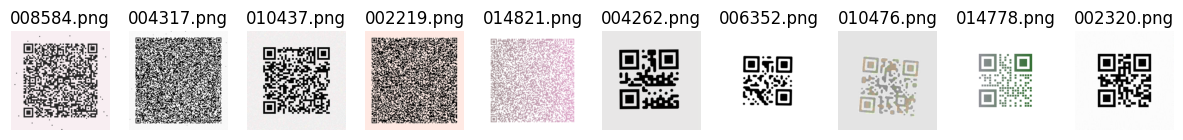

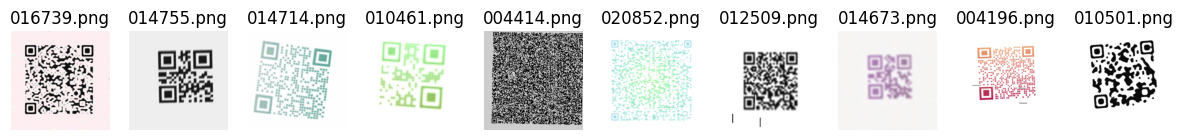

In [36]:
show_random_images("png/_recognized", n=10)
show_random_images("png/_not_recognized", n=10)

In [37]:
pipeline = Pipeline([
    grayscale
])
divide_imgs_by_scan("png/_not_recognized", pipeline=pipeline, pipeline_name="grayscale")

Moved 000001.png to grayscale_not_recognized
Moved 000005.png to grayscale_not_recognized
Moved 000007.png to grayscale_not_recognized
Moved 000012.png to grayscale_not_recognized
Moved 000014.png to grayscale_not_recognized
Moved 000015.png to grayscale_not_recognized
Moved 000017.png to grayscale_not_recognized
Moved 000018.png to grayscale_not_recognized
Moved 000019.png to grayscale_not_recognized
Moved 000022.png to grayscale_recognized
Moved 000023.png to grayscale_recognized
Moved 000024.png to grayscale_not_recognized
Moved 000025.png to grayscale_not_recognized
Moved 000026.png to grayscale_not_recognized
Moved 000028.png to grayscale_not_recognized
Moved 000029.png to grayscale_not_recognized
Moved 000030.png to grayscale_not_recognized
Moved 000031.png to grayscale_not_recognized
Moved 000033.png to grayscale_not_recognized
Moved 000034.png to grayscale_not_recognized
Moved 000035.png to grayscale_not_recognized
Moved 000036.png to grayscale_not_recognized
Moved 000038.png t

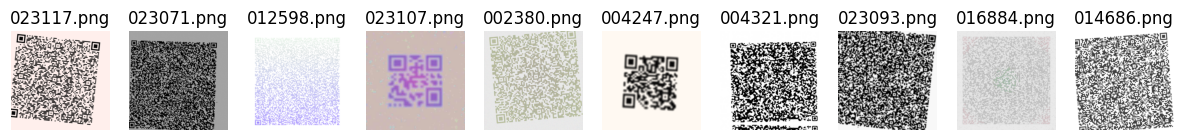

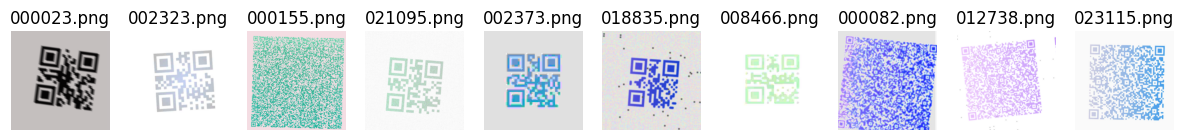

In [38]:
show_random_images("png/_not_recognized/grayscale_not_recognized", n=10)
show_random_images("png/_not_recognized/grayscale_recognized", n=10)